In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

In [2]:
# data from:
# https://www.kaggle.com/uciml/sms-spam-collection-dataset
!wget https://lazyprogrammer.me/course_files/spam.csv

--2024-04-16 09:31:33--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv.1’

spam.csv.1          100%[===================>] 491.86K  --.-KB/s    in 0.03s   

2024-04-16 09:31:34 (13.9 MB/s) - ‘spam.csv.1’ saved [503663/503663]



In [3]:
# file contains some invalid chars
# depending on which version of pandas you have
# an error may be thrown
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [6]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# rename columns to something better
df.columns = ['labels', 'data']

In [8]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<Axes: >

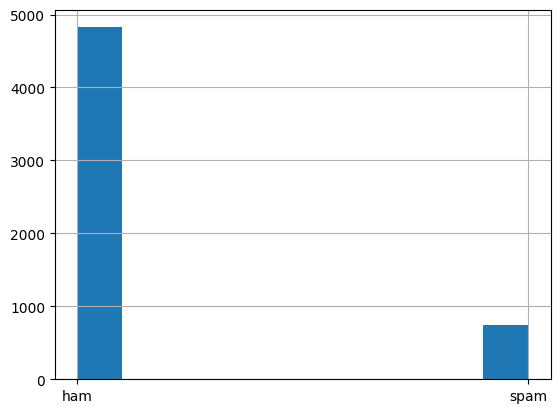

In [9]:
df['labels'].hist()

In [10]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].to_numpy()

In [11]:
# split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(
    df['data'], Y, test_size=0.33)

In [12]:
# try multiple ways of calculating features
# featurizer = TfidfVectorizer(decode_error='ignore')
# Xtrain = featurizer.fit_transform(df_train)
# Xtest = featurizer.transform(df_test)

featurizer = CountVectorizer(decode_error='ignore')
Xtrain = featurizer.fit_transform(df_train)
Xtest = featurizer.transform(df_test)

In [13]:
Xtrain

<3733x6881 sparse matrix of type '<class 'numpy.int64'>'
	with 49725 stored elements in Compressed Sparse Row format>

In [14]:
# create the model, train it, print scores
model = MultinomialNB()
model.fit(Xtrain, Ytrain)
print("train acc:", model.score(Xtrain, Ytrain))
print("test acc:", model.score(Xtest, Ytest))

train acc: 0.99464237878382
test acc: 0.9825992387166939


In [15]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)
print("train F1:", f1_score(Ytrain, Ptrain))
print("test F1:", f1_score(Ytest, Ptest))

train F1: 0.9797570850202428
test F1: 0.9330543933054393


In [16]:
cm = confusion_matrix(Ytrain, Ptrain)
cm

array([[3229,    5],
       [  15,  484]])

In [17]:
# visualize the data
def visualize(label):
  words = ''
  for msg in df[df['labels'] == label]['data']:
    msg = msg.lower()
    words += msg + ' '
  wordcloud = WordCloud(width=600, height=400).generate(words)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

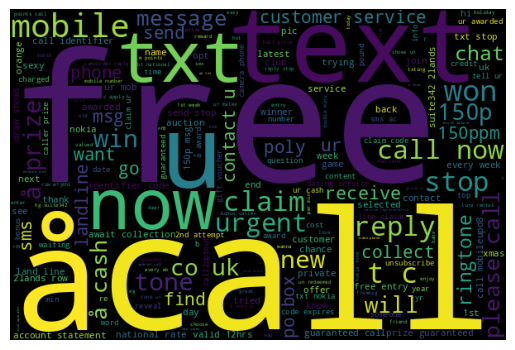

In [18]:
visualize('spam')

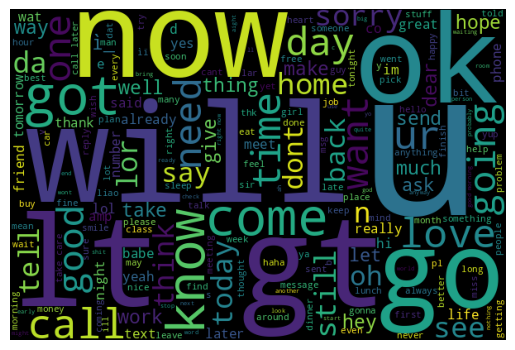

In [19]:
visualize('ham')

In [20]:
# see what we're getting wrong
X = featurizer.transform(df['data'])
df['predictions'] = model.predict(X)

In [21]:
# things that should be spam
sneaky_spam = df[(df['predictions'] == 0) & (df['b_labels'] == 1)]['data']
for msg in sneaky_spam:
  print(msg)

FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
Did you hear about the new \Divorce Barbie\"? It comes with all of Ken's stuff!"
SMS. ac sun0819 posts HELLO:\You seem cool
Hi I'm sue. I am 20 years old and work as a lapdancer. I love sex. Text me live - I'm i my bedroom now. text SUE to 89555. By TextOperator G2 1DA 150ppmsg 18+
Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?
Talk sexy!! Make new friends or fall in love in the worlds most discreet text dating service. Just text VIP to 83110 and see who you could meet.
Hello. We need some posh birds and chaps to user trial prods for champneys. Can i put you down? I need your address and dob asap. Ta r
Dont forget you can place as many FREE Requests with 1stchoice.co.uk as you wish. For more Information call 08707808226.
Got what it takes 2 take part in the WRC Rally in Oz? U can with

In [22]:
# things that should not be spam
# perhaps some are mislabeled?
not_actually_spam = df[(df['predictions'] == 1) & (df['b_labels'] == 0)]['data']
for msg in not_actually_spam:
  print(msg)

Finally the match heading towards draw as your prediction.
Waiting for your call.
We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us
Hey...Great deal...Farm tour 9am to 5pm $95/pax, $50 deposit by 16 May
Total video converter free download type this in google search:)
Unlimited texts. Limited minutes.
Mathews or tait or edwards or anderson
Update your face book status frequently :)
Gettin rdy to ship comp
I liked the new mobile
Nokia phone is lovly..
We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us
